MARKOV ICL - CLASSIFICATION (Softmax Output)
K=256, D=32, N=8, B=2, nodes=15
Method: direct_solve, Temperature: 1.0
Device: cpu

Creating GMM with discrete labels...
  GMM: 256 classes with labels randomly assigned from {1, ..., 32}
  First 10 class labels: [ 9. 10. 32. 25.  2. 16. 20.  7. 28.  2.]

Generating data...

Creating model...
  Initialized ICL Attention model (L=32 classes, attention over 8 context items)
  Label modulation: False
  Parameters: 65,145

Training...
Epoch  10 | Train: 58.32% | Val: 51.30% | IWL: 3.40% | ICL: 45.40%
Epoch  20 | Train: 91.74% | Val: 81.15% | IWL: 4.80% | ICL: 74.60%
Epoch  30 | Train: 99.63% | Val: 92.40% | IWL: 5.00% | ICL: 87.20%
Epoch  40 | Train: 99.99% | Val: 94.50% | IWL: 4.80% | ICL: 87.20%
Epoch  50 | Train: 100.00% | Val: 95.35% | IWL: 4.40% | ICL: 89.80%
Epoch  60 | Train: 100.00% | Val: 96.25% | IWL: 4.00% | ICL: 88.80%
Epoch  70 | Train: 100.00% | Val: 96.70% | IWL: 2.80% | ICL: 90.40%
Epoch  80 | Train: 100.00% | Val: 96.85% | IWL: 

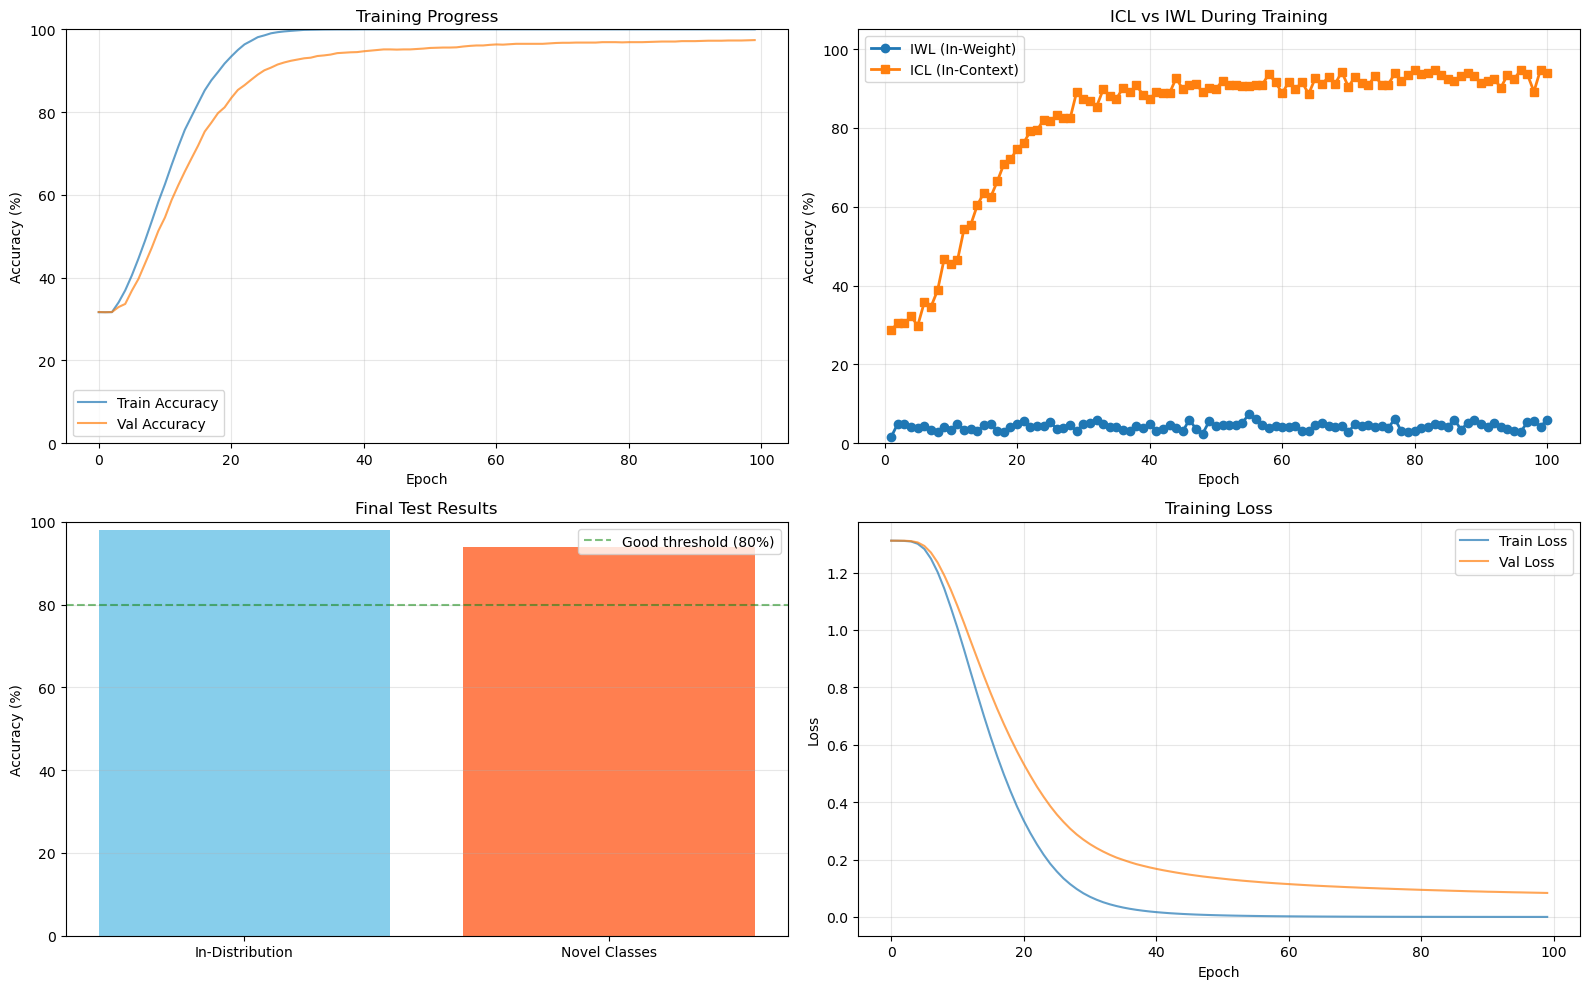


ICL/IWL SUMMARY
Final IWL Accuracy:        6.00%
Final ICL Accuracy:  94.00%


In [24]:
### Updated to use refactored code structure

# Import from refactored modules
import torch
import numpy as np
import os
import time
from torch.utils.data import DataLoader

# Import from new modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data, generate_iwl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl
from config import ExperimentConfig

L = 32
K = 256
D = 32
N = 8
B = 2
n_nodes = 15
epochs = 100
lr = 0.001
batch_size = 64
train_samples = 10000
val_samples = 2000
epsilon = 1e-4
seed = 42
exact_copy = True
method = 'direct_solve'
temperature = 1.0

# Set parameters
params = {
    'K': K,                      # Number of GMM classes
    'L': L,                      # Number of output classes (can be different from K)
    'D': D,                      # Dimension
    'N': N,                      # Context examples
    'B': B,                      # Burstiness
    'n_nodes': n_nodes,          # Markov nodes
    'epochs': epochs,            # Training epochs
    'lr': lr,                    # Learning rate
    'batch_size': batch_size,
    'train_samples': train_samples,
    'val_samples': val_samples,
    'epsilon': epsilon,          # Within-class noise
    'seed': seed,
    'exact_copy': exact_copy,    # Query is exact copy of context item
    'method': method,
    'temperature': temperature   # Softmax temperature
}



print("="*70)
print("MARKOV ICL - CLASSIFICATION (Softmax Output)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print(f"Method: {params['method']}, Temperature: {params['temperature']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM with discrete labels (1 to L)
print("Creating GMM with discrete labels...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], L=params['L'], epsilon=params['epsilon'], seed=params['seed'])
print(f"  GMM: {params['K']} classes with labels randomly assigned from {{1, ..., {params['L']}}}")
print(f"  First 10 class labels: {gmm.class_to_label[:min(10, params['K'])].numpy()}")

# Generate data
print("\nGenerating data...")
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'])
val_data = generate_icl_gmm_data(gmm, params['val_samples'], params['N'], 
                                 novel_classes=False, exact_copy=params['exact_copy'], 
                                 B=params['B'], L=params['L'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ICLGMMDataset(val_data), batch_size=params['batch_size'],
                       collate_fn=collate_fn)

# Create model
print("\nCreating model...")
model = MatrixTreeMarkovICL(n_nodes=params['n_nodes'], z_dim=params['D'], 
                           L=params['L'], N=params['N'])

# Train with ICL/IWL tracking
start_time = time.time()
print("\nTraining...")
print("="*70)
history = train_model(model, train_loader, val_loader, device, 
                     n_epochs=params['epochs'], lr=params['lr'], 
                     method=params['method'], temperature=params['temperature'],
                     gmm=gmm, N=params['N'], B=params['B'], 
                     L=params['L'], exact_copy=params['exact_copy'],
                     eval_frequency=1, n_eval_samples=500)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test
results = test_icl(model, gmm, params['N'], device, n_samples=1000, 
                  exact_copy=params['exact_copy'], B=params['B'], 
                  method=params['method'], L=params['L'],
                  temperature=params['temperature'])

# # Save model
# os.makedirs('results', exist_ok=True)
# model_path = f'results/markov_icl_gmm_K{config.K}_N{config.N}_classification_T{config.temperature:.1f}.pt'
# torch.save(model.state_dict(), model_path)
# print(f"\n✓ Saved: {model_path}")

# Plot training history with ICL/IWL metrics
try:
    import matplotlib.pyplot as plt
    
    # Extract ICL/IWL metrics (filter out None values)
    epochs_eval = [i+1 for i, val in enumerate(history['iwl_acc']) if val is not None]
    iwl_acc = [val for val in history['iwl_acc'] if val is not None]
    icl_acc = [val for val in history['icl_acc'] if val is not None]
    #icl_swap_acc = [val for val in history['icl_swap_acc'] if val is not None]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Training/Val Accuracy
    ax1 = axes[0, 0]
    ax1.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    ax1.plot(history['val_acc'], label='Val Accuracy', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    
    # Plot 2: ICL vs IWL over time
    ax2 = axes[0, 1]
    if len(iwl_acc) > 0:
        ax2.plot(epochs_eval, iwl_acc, 'o-', label='IWL (In-Weight)', linewidth=2, markersize=6)
        ax2.plot(epochs_eval, icl_acc, 's-', label='ICL (In-Context)', linewidth=2, markersize=6)
        #ax2.plot(epochs_eval, icl_swap_acc, '^-', label='ICL Label Swap', linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('ICL vs IWL During Training')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 105])
    else:
        ax2.text(0.5, 0.5, 'No ICL/IWL data\n(set gmm parameter)', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Plot 3: Final test results
    ax3 = axes[1, 0]
    ax3.bar(['In-Distribution', 'Novel Classes'], 
            [results['in_dist'], results['novel_classes']],
            color=['skyblue', 'coral'])
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Final Test Results')
    ax3.axhline(y=80, color='g', linestyle='--', label='Good threshold (80%)', alpha=0.5)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 100])
    
    # Plot 4: Training/Val Loss
    ax4 = axes[1, 1]
    ax4.plot(history['train_loss'], label='Train Loss', alpha=0.7)
    ax4.plot(history['val_loss'], label='Val Loss', alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.set_title('Training Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if len(iwl_acc) > 0:
        print("\n" + "="*70)
        print("ICL/IWL SUMMARY")
        print("="*70)
        print(f"Final IWL Accuracy:        {iwl_acc[-1]:.2f}%")
        print(f"Final ICL Accuracy:  {icl_acc[-1]:.2f}%")
        #print(f"Final ICL Swap Accuracy:   {icl_swap_acc[-1]:.2f}%")
        print("="*70)
    
except ImportError:
    print("\n(Install matplotlib to see training plots)")

In [20]:
L = 32
K = 256
D = 8
N = 4
B = 2
n_nodes = 15
epochs = 100
lr = 0.001
batch_size = 64
train_samples = 10000
val_samples = 2000
epsilon = 1e-4
seed = 42
exact_copy = True
method = 'direct_solve'
temperature = 1.0

# Set parameters
params = {
    'K': K,                      # Number of GMM classes
    'L': L,                      # Number of output classes (can be different from K)
    'D': D,                      # Dimension
    'N': N,                      # Context examples
    'B': B,                      # Burstiness
    'n_nodes': n_nodes,          # Markov nodes
    'epochs': epochs,            # Training epochs
    'lr': lr,                    # Learning rate
    'batch_size': batch_size,
    'train_samples': train_samples,
    'val_samples': val_samples,
    'epsilon': epsilon,          # Within-class noise
    'seed': seed,
    'exact_copy': exact_copy,    # Query is exact copy of context item
    'method': method,
    'temperature': temperature   # Softmax temperature
}



print("="*70)
print("MARKOV ICL - CLASSIFICATION (Softmax Output)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print(f"Method: {params['method']}, Temperature: {params['temperature']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM with discrete labels (1 to L)
print("Creating GMM with discrete labels...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], L=params['L'], epsilon=params['epsilon'], seed=params['seed'])



icl_data = generate_icl_gmm_data(gmm, 100, N, novel_classes=False, exact_copy=True, B=2, L=None)
iwl_data = generate_iwl_gmm_data(gmm, 100, N, B=2)

MARKOV ICL - CLASSIFICATION (Softmax Output)
K=256, D=8, N=4, B=2, nodes=15
Method: direct_solve, Temperature: 1.0
Device: cpu

Creating GMM with discrete labels...


In [21]:
icl_data[0]

(tensor([[ 0.1139,  0.1577,  0.5384,  0.4527, -0.0410,  0.4846, -0.1700, -0.3502],
         [ 0.1139,  0.1577,  0.5384,  0.4527, -0.0411,  0.4846, -0.1700, -0.3501],
         [ 0.2258, -0.1542, -0.3545,  0.1337,  0.0152,  0.2072, -0.4839,  0.3949],
         [ 0.2258, -0.1542, -0.3544,  0.1337,  0.0151,  0.2072, -0.4839,  0.3948],
         [ 0.2258, -0.1542, -0.3544,  0.1337,  0.0151,  0.2072, -0.4839,  0.3948]]),
 tensor([14., 14.,  9.,  9.]),
 tensor(9.))

In [22]:
iwl_data[40]

(tensor([[-2.9242e-01,  5.5188e-01, -3.8720e-01,  4.1913e-01,  4.2002e-01,
           7.2672e-01,  2.3346e-01, -3.9167e-01],
         [-2.9248e-01,  5.5186e-01, -3.8717e-01,  4.1916e-01,  4.2000e-01,
           7.2675e-01,  2.3346e-01, -3.9162e-01],
         [-1.0370e-01,  7.4487e-01, -3.8506e-02,  2.1511e-01,  2.7907e-01,
           2.7668e-01, -2.2858e-02, -1.1390e-04],
         [-1.0373e-01,  7.4477e-01, -3.8413e-02,  2.1504e-01,  2.7911e-01,
           2.7668e-01, -2.2881e-02, -9.0079e-05],
         [ 1.1779e-01, -4.4285e-01, -2.0315e-01, -6.7386e-01, -3.4176e-01,
           1.3004e-01, -2.0454e-01,  4.3748e-01]]),
 tensor([15., 15.,  8.,  8.]),
 tensor(6.))